In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
#from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
imges_path = '../input/ham1000-segmentation-and-classification/images/'
labels_path = '../input/ham1000-segmentation-and-classification/masks/'

In [3]:
imge_path =  os.listdir(imges_path)
label_path = os.listdir(labels_path)

In [25]:
image_path_test = imge_path[:100]
label_path_test = label_path[:100]

In [26]:
X = []
image_name = []

for file in image_path_test :
    if file.endswith(('.jpg')):
        image = plt.imread(imges_path +file)
        image = cv2.resize(image, (256,256))
        # image = image.astype(np.float32)
        X.append(image)
        image_name.append(file)
    else:
        continue

In [27]:
y = []
label_name = []
for file in label_path_test : 
        label = plt.imread(labels_path+ file)
        label = cv2.resize(label, (256,256))
        # label = label.astype(np.float32)
        if len(label.shape)==3:
            y.append(label[:,:,0])
        else:
            y.append(label)
        label_name.append(file)

In [28]:
X = np.array(X)
y = np.array(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
# del X
# del y

In [31]:
print(X_test.shape)
print(y_test.shape)

(30, 256, 256, 3)
(30, 256, 256)


In [47]:
def unet(input_size=(256,256,3)):
    inputs = Input(shape = input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=inputs, outputs=conv10)

In [48]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       activation_36[0][0]              
____________________________________________________________________________________________

In [49]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [35]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)

schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-0, 1e-1, 1e-2])

lr = 1e-1 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [51]:
model.compile(optimizer='adam', loss=[dice_coef_loss], metrics=[dice_coef , iou])


In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid) ,callbacks=[callback])

Epoch 1/5
3/3 [==============================] - 4s 677ms/step - loss: 0.5793 - dice_coef: 0.4468 - iou: 0.2887 - val_loss: 0.6693 - val_dice_coef: 0.3307 - val_iou: 0.1981
Epoch 2/5
3/3 [==============================] - 2s 493ms/step - loss: 0.5504 - dice_coef: 0.4384 - iou: 0.2819 - val_loss: 0.5339 - val_dice_coef: 0.4661 - val_iou: 0.3038
Epoch 3/5
3/3 [==============================] - 2s 502ms/step - loss: 0.5312 - dice_coef: 0.4889 - iou: 0.3242 - val_loss: 0.9987 - val_dice_coef: 0.0013 - val_iou: 6.3425e-04
Epoch 4/5
3/3 [==============================] - 2s 493ms/step - loss: 0.5237 - dice_coef: 0.4456 - iou: 0.2880 - val_loss: 0.5622 - val_dice_coef: 0.4378 - val_iou: 0.2802
Epoch 5/5
3/3 [==============================] - 2s 490ms/step - loss: 0.5486 - dice_coef: 0.4615 - iou: 0.3026 - val_loss: 1.0000 - val_dice_coef: 8.0538e-10 - val_iou: 1.8688e-10


In [41]:
x=tf.keras.models.load_model('./model1.h5')

ValueError: No model found in config file.

In [55]:
from keras.models import load_model
base_model=load_model('./model3.h5',compile=False)

In [56]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       activation_36[0][0]              
____________________________________________________________________________________________

In [60]:
x=model.predict(X_test)

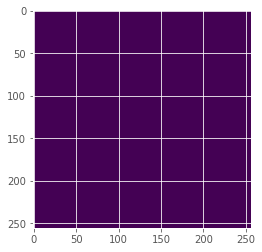

In [69]:
plt.imshow(x[0])

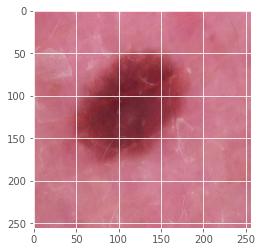

In [63]:
plt.imshow(X_test[10])

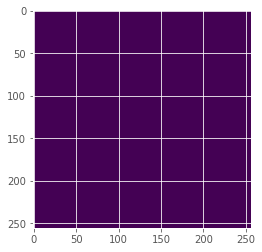

In [67]:
plt.imshow(x[0])

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
model.save('model3.h5')

In [ ]:
# import os 
# os.remove('model.h5')